In [6]:
import configparser
from snowflake.snowpark import Session
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import PandasSeries, PandasDataFrame
from snowflake.snowpark.functions import col
from snowflake.snowpark.functions import when_matched, when_not_matched

import scalene
from scalene import scalene_profiler
import numpy as np
import pandas as pd
from scipy.special import factorial
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

import timeit

import matplotlib.pyplot as plt

### Questions to answer
- How much more efficient do vectorized functions need to be to vanilla python?
- How does batch size affect performance?
- How does volume of data affect vectorization performance?
- calc speed on snowflake vs locally
    - compare wh size as well

# Benchmarking Functions

In [62]:
def create_test_array(array_len_power = 6):
    d1 = np.linspace(0, 5, 10**array_len_power)
    d2 = np.linspace(5, 10, 10**array_len_power)
    test_array = np.stack((d1,d2), axis = -1)
    return test_array

def add_rows(test_array):
    return [row[0] + row[1] for row in test_array]

def add_rows_vectorized(test_array):
    df = pd.DataFrame(test_array)
    return (df[0] + df[1]).values.tolist()


def calc_factorials(test_array):
    fact_sum = []
    for row in test_array:
        i = 1
        for i in range(0, row[0].astype(int) + 1):
            i *= i
        j = 1
        for j in range(0, row[1].astype(int) + 1):
            j *= j
        fact_sum.append(i + j)
    return fact_sum
    
def factorials_vectorized(test_array):
    df = pd.DataFrame(test_array)
    factorial_sum_list = (factorial(df[0].astype(int).values) + factorial(df[1].astype(int).values)).tolist()
    return factorial_sum_list

In [71]:
test_array_lens = [2, 4, 6, 7]


add_row_results_list = []
add_row_vec_result_list = []
calc_factorials_result_list = []
factorials_vectorized_result_list = []


add_row_results_best = []
add_row_vec_result_best = []
calc_factorials_result_best = []
factorials_vectorized_result_best = []

for i in test_array_lens:
    test_array = create_test_array(array_len_power = i)
    
    add_row_result = %timeit -o -n 1 -r 5 add_rows(test_array)
    add_row_results_list.append(add_row_result.all_runs)
    add_row_results_best.append(add_row_result.best)
    
    
    add_row_vec_result = %timeit -o -n 1 -r 5 add_rows_vectorized(test_array)
    add_row_vec_result_list.append(add_row_vec_result.all_runs)
    add_row_vec_result_best.append(add_row_vec_result.best)
    
    calc_factorials_result = %timeit -o -n 1 -r 5 calc_factorials(test_array)
    calc_factorials_result_list.append(calc_factorials_result.all_runs)
    calc_factorials_result_best.append(calc_factorials_result.best)
    
    factorials_vectorized_result = %timeit -o -n 1 -r 5 factorials_vectorized(test_array)
    factorials_vectorized_result_list.append(factorials_vectorized_result.all_runs)
    factorials_vectorized_result_best.append(factorials_vectorized_result.best)

33.9 µs ± 5.69 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
200 µs ± 56.7 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
266 µs ± 6.51 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
393 µs ± 205 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
3.38 ms ± 331 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
633 µs ± 85.7 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
27.6 ms ± 848 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
604 µs ± 67.9 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
322 ms ± 4.62 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
27.9 ms ± 338 µs per loop (mean ± std. dev. of 5 runs, 1 loop each)
2.7 s ± 17.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
51.4 ms ± 1.19 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
3.06 s ± 7.43 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
280 ms ± 2.05 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
26.6 s ± 166 ms per loop (mean ± std. dev. of 5 

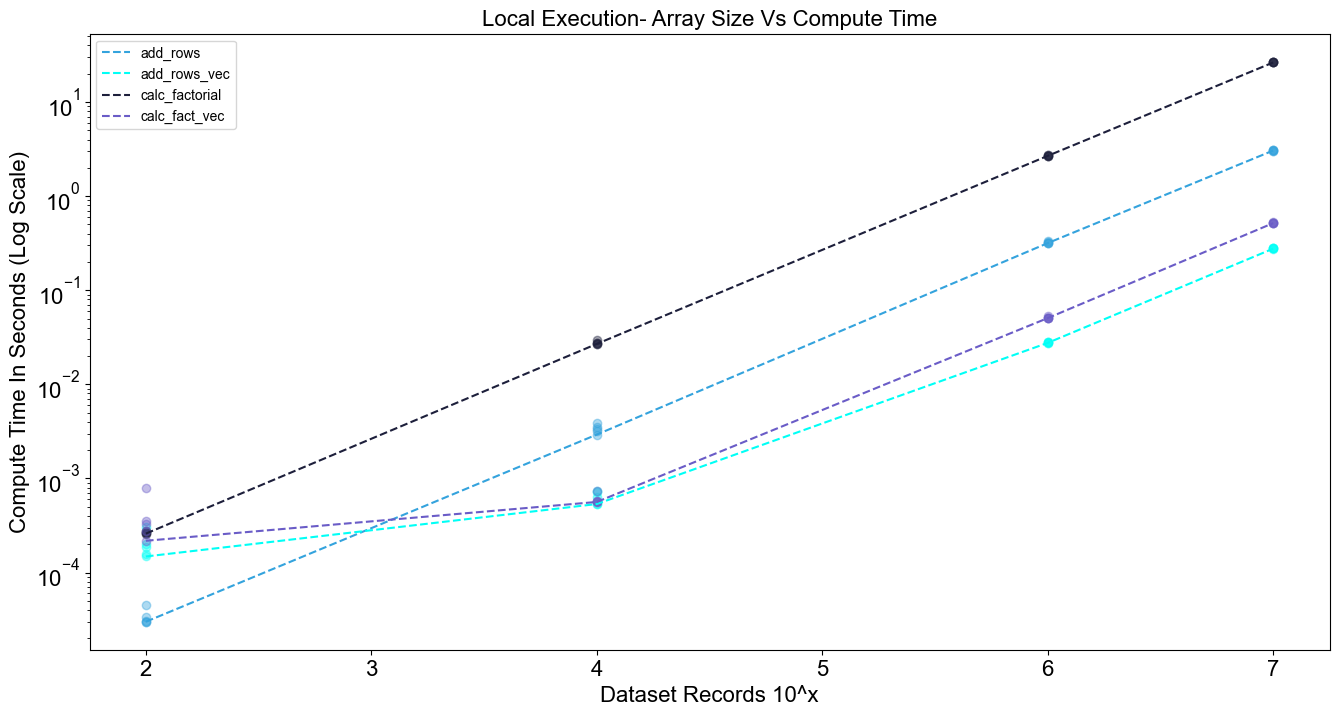

In [72]:
## this plot helps show the initial overhead of moving the data to cpython
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(16,8))

for i, lens in enumerate(test_array_lens):
    plt.scatter([lens]*5, add_row_results_list[i], color = '#34A3DD', alpha = 0.4)
    plt.scatter([lens]*5, add_row_vec_result_list[i], color ='#00FFF6', alpha = 0.4)
    plt.scatter([lens]*5, calc_factorials_result_list[i], color = '#1D1F3B', alpha = 0.4)
    plt.scatter([lens]*5, factorials_vectorized_result_list[i], color = '#6A5CC7', alpha = 0.4)

    
plt.plot(test_array_lens, add_row_results_best, label = "add_rows", color = '#34A3DD',  linestyle='--')
plt.plot(test_array_lens, add_row_vec_result_best, label = "add_rows_vec", color = '#00FFF6', linestyle='--')
plt.plot(test_array_lens, calc_factorials_result_best, label = "calc_factorial", color = '#1D1F3B', linestyle='--')
plt.plot(test_array_lens, factorials_vectorized_result_best, label = "calc_fact_vec", color = '#6A5CC7', linestyle='--')

plt.yscale('log')
plt.title("Local Execution- Array Size Vs Compute Time")
plt.ylabel('Compute Time In Seconds (Log Scale)')
plt.xlabel('Dataset Records 10^x')
plt.legend()
#plt.savefig('result_charts/local_execution_example.png', dpi=600, bbox_inches='tight')
plt.show()

# Create data in Snowflake

In [209]:

def upload_to_table(conn, df, table, db, schema, dry=True):
    # create the table if not exists and upload data
    
    # create columns based on pandas datatypes
    column_name_sql_list = []
    for column in df.columns:
        if (df[column].dtype.name == "int" or df[column].dtype.name == "int64"):
            col_name_dtype = f"""{column} int """
            
        elif df[column].dtype.name == "object":
            col_name_dtype = f"""{column} varchar """
            
        elif df[column].dtype.name == "datetime64[ns]":
            col_name_dtype = f"""{column} datetime """
            
        elif df[column].dtype.name == "float64":
            col_name_dtype = f"""{column} number """ 
            
        elif df[column].dtype.name == "bool" :
            col_name_dtype = f"""{column} boolean """  
        
        else:
            col_name_dtype = f"""{column} boolean """
        
        column_name_sql_list.append(col_name_dtype)
        
    column_name_sql_str = ", ".join(column_name_sql_list)
    
    create_tbl_sql = f""" create table if not exists {db}.{schema}.{table} ({column_name_sql_str}) """
    
    if dry:
        print(create_tbl_sql)
        
    else:
        conn.cursor().execute(create_tbl_sql)
        
        success, num_chunks, num_rows, output = write_pandas(
                conn = conn,
                df = df,
                table_name = table
        )
        
        return success
    

In [211]:
conn = snowflake.connector.connect(
        account = config['snowflake']['account'],
        user = config['snowflake']['user'],
        password = config['snowflake']['password'],
        role=config['snowflake']['role'],
        warehouse = config['snowflake']['warehouse'],
        database=  config['snowflake']['database'],
        schema= config['snowflake']['schema']
        )


test_array = create_test_array(array_len_power = 8)

df = pd.DataFrame(test_array)
df = df.rename({0: "A", 1: "B"}, axis = 1)

table_name = "UDF_TEST"
schema = config['snowflake']['schema']
db = config['snowflake']['database']

# upload 100M rows--
upload_to_table(conn, df, table_name, db, schema, dry = True)
                

True

# Create UDFs
- saving functions to python files first to make version control easier

In [2]:
config = configparser.ConfigParser()
config.read('snowflake_creds.config')

connection_parameters = {
    "account": config['snowflake']['account'],
    "user": config['snowflake']['user'],
    "password": config['snowflake']['password'],
    "role": config['snowflake']['role'],
    "warehouse": config['snowflake']['warehouse'],
    "database": config['snowflake']['database'],
    "schema": config['snowflake']['schema']
}

session = Session.builder.configs(connection_parameters).create()

In [3]:
stage_name = "snowpark_functions"
session.sql(f""" create stage if not exists {stage_name} directory = (enable=true);""").collect()

[Row(status='SNOWPARK_FUNCTIONS already exists, statement succeeded.')]

In [232]:
%%writefile "add_rows_simple.py"

def add_rows_simple(A, B):
    return A + B

Overwriting add_rows_simple.py


In [5]:

from add_rows_simple import add_rows_simple


@udf(name = "ADD_ROWS_SIMPLE",
     is_permanent = True,
     stage_location = f"@{stage_name}",
     replace = True,
     imports = [("add_rows_simple.py", "add_rows_simple")],
     session = session)

def sf_add_rows(A: float,
                B: float) -> int:
    
    row_sum = add_rows_simple(A, B)
    return row_sum

In [6]:
session.sql(""" select add_rows_simple(*) from demodb.udf_testing.udf_test limit 10;""").show()

[Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5),
 Row(ADD_ROWS_SIMPLE(*)=5)]

In [229]:
%%writefile "add_rows_vectorized.py"
import pandas as pd

def add_rows_vectorized(df):
    return df[0] + df[1]

Writing add_rows_vectorized.py


In [10]:

from add_rows_vectorized import add_rows_vectorized

@udf(name = "ADD_ROWS_VECTORIZED",
     is_permanent = True,
     stage_location = f"@{stage_name}",
     replace = True,
     imports = [("add_rows_vectorized.py", "add_rows_vectorized")],
     packages = ["pandas", "numpy"],
     session = session,
     max_batch_size = 1000000)

def sf_add_rows_vec(df: PandasDataFrame[float, float]) -> PandasSeries[int]:
    
    sum_vector = add_rows_vectorized(df)
    
    return sum_vector

The version of package numpy in the local environment is 1.23.3, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment


In [11]:
session.sql(""" select add_rows_vectorized(*) from demodb.udf_testing.udf_test limit 10;""").show()

[Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5),
 Row(ADD_ROWS_VECTORIZED(*)=5)]

In [54]:
%%writefile "calc_factorials_simple.py"

def calc_factorials_simple(A, B):

    a = 1
    b = 1
    
    for i in range(1, int(A) + 1):
        a *= i
    
    for j in range(1, int(B) + 1):
        b *= j

    fact_sum = a + b
    
    return fact_sum
    

Overwriting calc_factorials_simple.py


In [55]:

from calc_factorials_simple import calc_factorials_simple


@udf(name = "CALC_FAC_SIMPLE",
     is_permanent = True,
     stage_location = f"@{stage_name}",
     replace = True,
     imports = [("calc_factorials_simple.py", "calc_factorials_simple")],
     session = session)

def sf_cal_fac(A: float,
               B: float) -> int:
    
    factorial_sum = calc_factorials_simple(A, B)
    return factorial_sum

In [56]:
session.sql(""" select calc_fac_simple(*) from demodb.udf_testing.udf_test limit 10;""").show()

[Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121),
 Row(CALC_FAC_SIMPLE(*)=121)]

In [6]:
%%writefile "factorials_vectorized.py"

import pandas as pd
from scipy.special import factorial

def factorials_vectorized(df):
    df['factorial_sum'] = factorial(df[0].astype(int).values) + factorial(df[1].astype(int).values)
    return df['factorial_sum']

Writing factorials_vectorized.py


In [10]:

from factorials_vectorized import factorials_vectorized

@udf(name = "CALC_FAC_VECTORIZED",
     is_permanent = True,
     stage_location = f"@{stage_name}",
     replace = True,
     imports = [("factorials_vectorized.py", "factorials_vectorized")],
     packages = ["pandas", "numpy", "scipy"],
     session = session,
     max_batch_size = 1000000)

def sf_add_rows_vec(df: PandasDataFrame[float, float]) -> PandasSeries[int]:
    
    sum_factorials = factorials_vectorized(df)
    
    return sum_factorials

The version of package numpy in the local environment is 1.23.3, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment
The version of package scipy in the local environment is 1.9.3, which does not fit the criteria for the requirement scipy. Your UDF might not work when the package version is different between the server and your local environment


In [11]:
session.sql(""" select calc_fac_vectorized(*) from demodb.udf_testing.udf_test limit 10;""").collect()

[Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121),
 Row(CALC_FAC_VECTORIZED(*)=121)]

# Run UDFs

In [58]:
# double check table
session.sql(""" select * from demodb.udf_testing.udf_test """).show()

-------------
|"A"  |"B"  |
-------------
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
|0    |5    |
-------------



In [112]:
conn = snowflake.connector.connect(
        account = config['snowflake']['account'],
        user = config['snowflake']['user'],
        password = config['snowflake']['password'],
        role=config['snowflake']['role'],
        warehouse = config['snowflake']['warehouse'],
        database=  config['snowflake']['database'],
        schema= config['snowflake']['schema']
        )

In [185]:
# run all udfs on various sized tables on Snowflake

test_array_lens = [2, 4, 6, 8]
num_loops = 10
udf_names = ['add_rows_simple', 'add_rows_vectorized', 'calc_fac_simple',  'calc_fac_vectorized']
warehouses = ['SMALL_TEST_WH', 'MEDIUM_TEST_WH', 'LARGE_TEST_WH']
query_ids = []
udf_results = []
length_results = []
loop_num = []
cur = conn.cursor()

for loop in range(0, num_loops):
    for warehouse in warehouses:
        cur.execute(f""" use warehouse {warehouse} """)

        for udf_name in udf_names:
            for record_power in test_array_lens: 

                records_returned = 10 ** record_power

                # lets do this async instead
                #conn.cursor().execute(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                cur.execute_async(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                query_id = cur.sfqid
                #print(query_id)
                query_ids.append(query_id)
                udf_results.append(udf_name)
                length_results.append(records_returned)
                loop_num.append(loop_num)


In [201]:
# rows to return
history_rows = 5000
df = session.sql( f""" select query_id, total_elapsed_time, compilation_time, execution_time, rows_produced, warehouse_name, query_text from table(information_schema.query_history(result_limit => {history_rows})) order by start_time desc """)

results_df = df.to_pandas()

In [202]:
results_df.to_csv('query_summary.csv')

In [ ]:
results_df = pd.read_csv('query_summary.csv', index_col=False)

In [203]:
results_df.head()

,QUERY_ID,TOTAL_ELAPSED_TIME,COMPILATION_TIME,EXECUTION_TIME,ROWS_PRODUCED,WAREHOUSE_NAME,QUERY_TEXT
0,01a7d450-0001-82ae-0000-0004f1871ac9,-1666564837440,32,0,0,COMPUTE_WH,"select query_id, total_elapsed_time, compilati..."
1,01a7d44c-0001-82ae-0000-0004f1871ac5,1280,551,811,760,COMPUTE_WH,"select query_id, total_elapsed_time, compilati..."
2,01a7d440-0001-82ad-0000-0004f1872a85,1137,499,741,759,COMPUTE_WH,"select query_id, total_elapsed_time, compilati..."
3,01a7d437-0001-82ad-0000-0004f1872a81,77515,136,65381,100000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...
4,01a7d437-0001-82ae-0000-0004f1871ab5,26019,168,7507,1000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...


In [215]:
query_ids_string = '|'.join(query_ids)

results_df = results_df[results_df['QUERY_ID'].str.contains(query_ids_string)]

# add in udf function that was used:
udf_df = pd.DataFrame({"QUERY_ID": query_ids, "UDF": udf_results})

joined_df = results_df.merge(udf_df, left_on = 'QUERY_ID', right_on = "QUERY_ID", how = 'left')



In [216]:
joined_df

,QUERY_ID,TOTAL_ELAPSED_TIME,COMPILATION_TIME,EXECUTION_TIME,ROWS_PRODUCED,WAREHOUSE_NAME,QUERY_TEXT,UDF
0,01a7d437-0001-82ad-0000-0004f1872a81,77515,136,65381,100000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
1,01a7d437-0001-82ae-0000-0004f1871ab5,26019,168,7507,1000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
2,01a7d437-0001-82ad-0000-0004f1872a79,21150,215,7371,10000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
3,01a7d437-0001-82ad-0000-0004f1872a75,21618,260,11622,100,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
4,01a7d437-0001-82ae-0000-0004f1871ab1,58927,280,48945,100000000,LARGE_TEST_WH,select calc_fac_simple(*) from demodb.udf_test...,calc_fac_simple


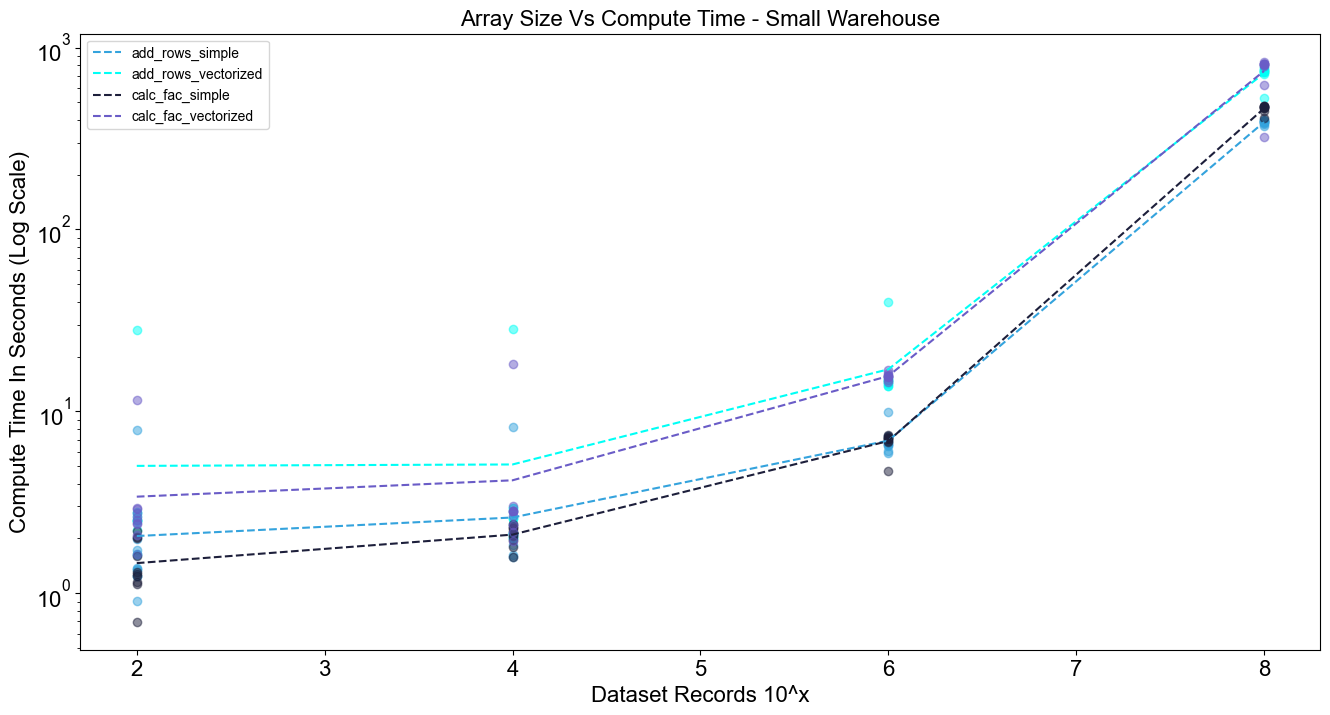

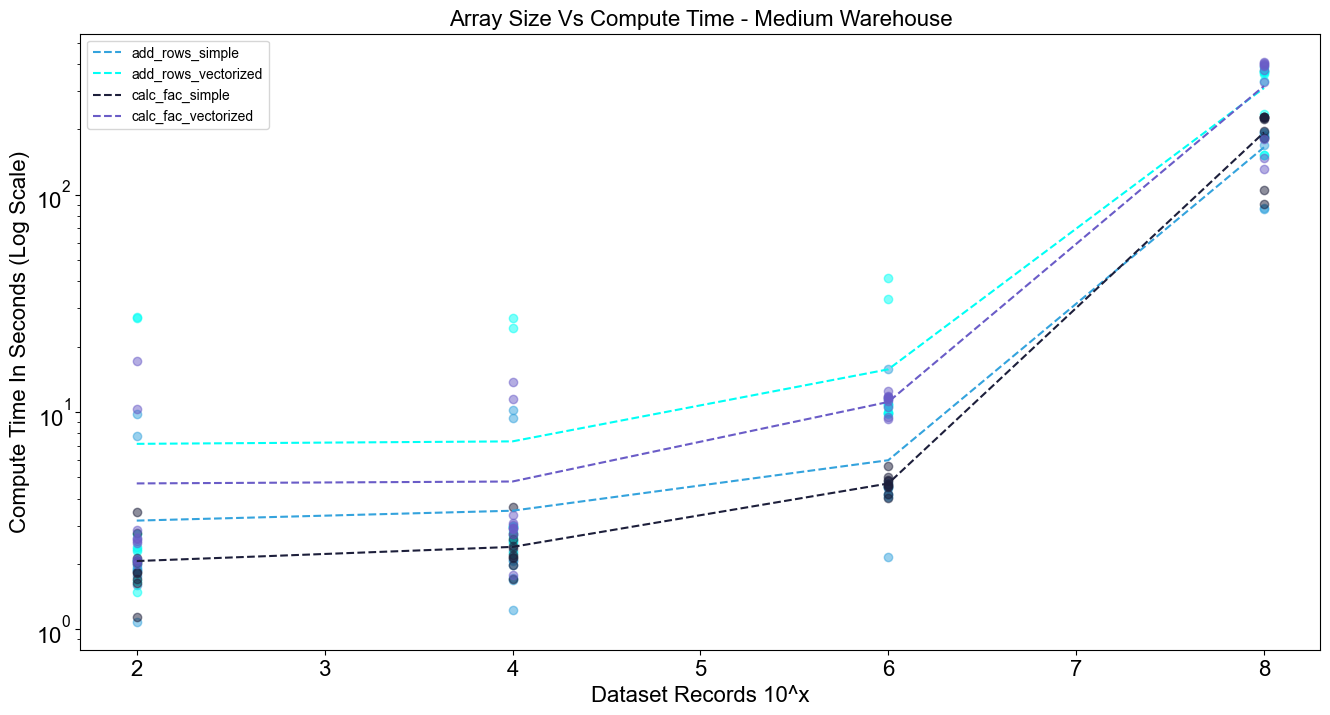

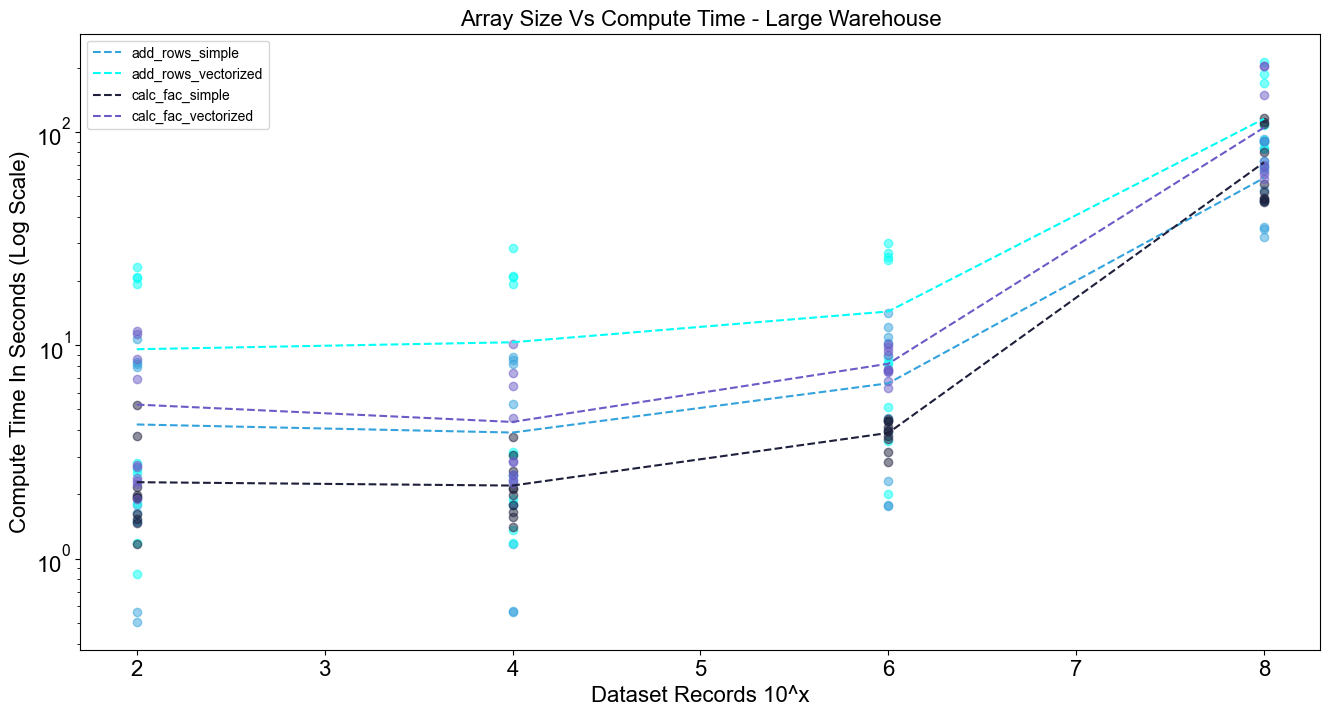

In [227]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16



#plot results
udf_to_color = {'add_rows_simple': '#34A3DD', 
                'add_rows_vectorized': '#00FFF6',
                'calc_fac_simple': '#1D1F3B',
                'calc_fac_vectorized': '#6A5CC7'
                }


for warehouse in warehouses:
    plt.figure(figsize=(16,8))
    
    results_subset_df = joined_df[joined_df['WAREHOUSE_NAME'] == warehouse]
    
    for udf_name in udf_names:
        udf_results_subset_df = results_subset_df[results_subset_df['UDF'] == udf_name]
        
        dataset_size = np.log10(udf_results_subset_df['ROWS_PRODUCED'].values).tolist()
        execution_time = (udf_results_subset_df['EXECUTION_TIME'] / 1000).values.tolist()
        
        plt.scatter(dataset_size, execution_time, color = udf_to_color[udf_name], alpha = 0.5)
    
        mean_exeuction_time = (udf_results_subset_df.groupby(by = ['ROWS_PRODUCED'])['EXECUTION_TIME'].mean()/1000).values.tolist()
        dataset_size_single = np.sort(np.log10(udf_results_subset_df['ROWS_PRODUCED'].unique())).tolist()


        plt.plot(dataset_size_single, mean_exeuction_time, label = f"{udf_name}", color = udf_to_color[udf_name],  linestyle='--')
    

    plt.yscale('log')
    plt.title(f"""Array Size Vs Compute Time - {warehouse.split("_")[0].capitalize()} Warehouse""")
    plt.ylabel('Compute Time In Seconds (Log Scale)')
    plt.xlabel('Dataset Records 10^x')
    plt.legend()
    #plt.savefig(f'result_charts/snowflake_execution_example_{warehouse}.png', dpi=600, bbox_inches='tight')
    plt.show()
    

## Conclusions/Lessons:
(tenative)
- vectorize arrays mainly for convieneince and not for performance
    - snowflake seems to do a good job of paralleizing vanilla python
    - vectorization improvements don't make up for needing to import packages like pandas
- warehouse size matters - almost linearly?
- pushing compute to the cloud is a great option for large dataset - benifits on over 1M records (xxx vs 80s)
- Take advantage of async execution
- execution times vary
    - local execution might be ideal if your dataset fits in memory and your computer is decent

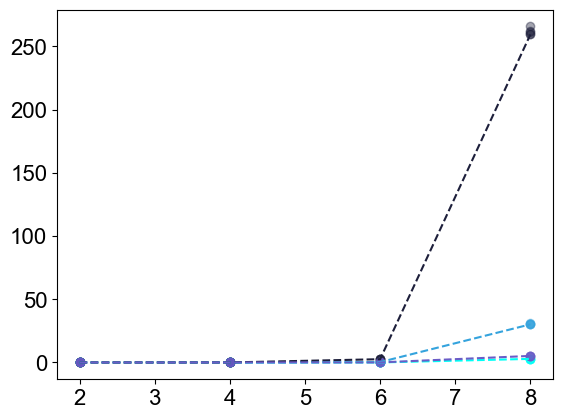

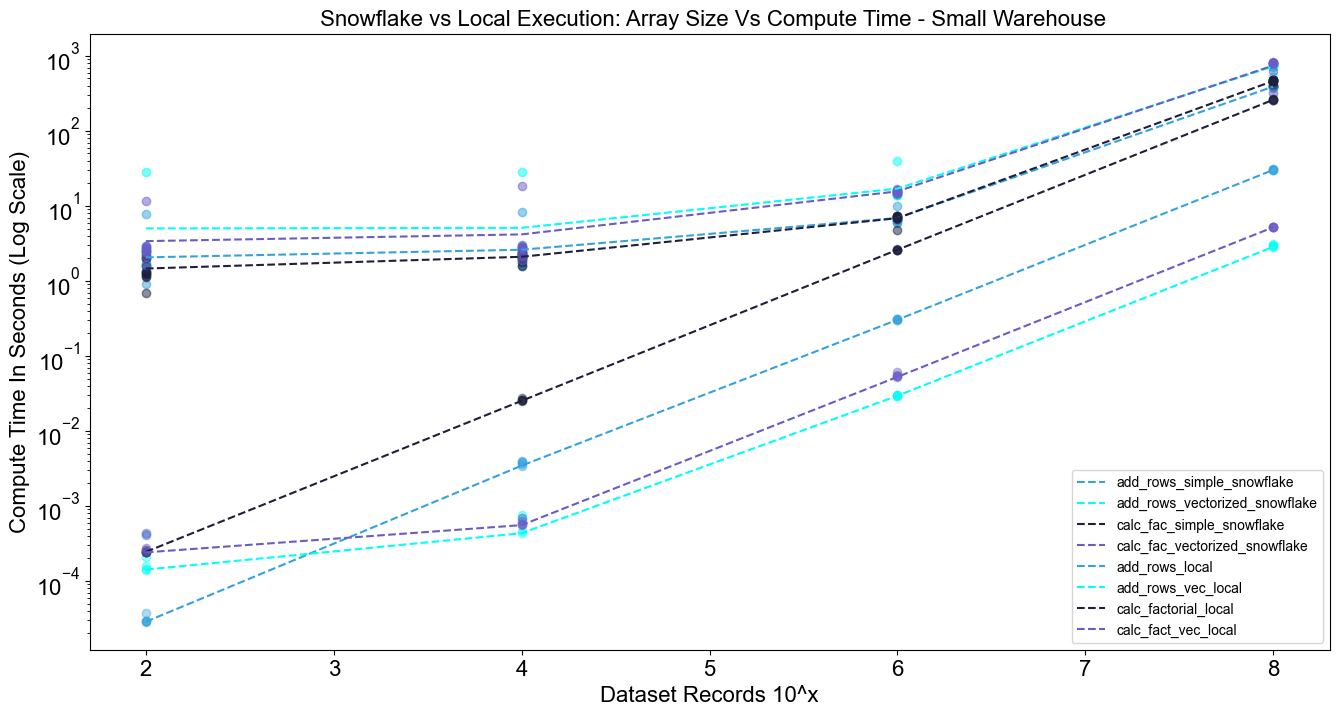

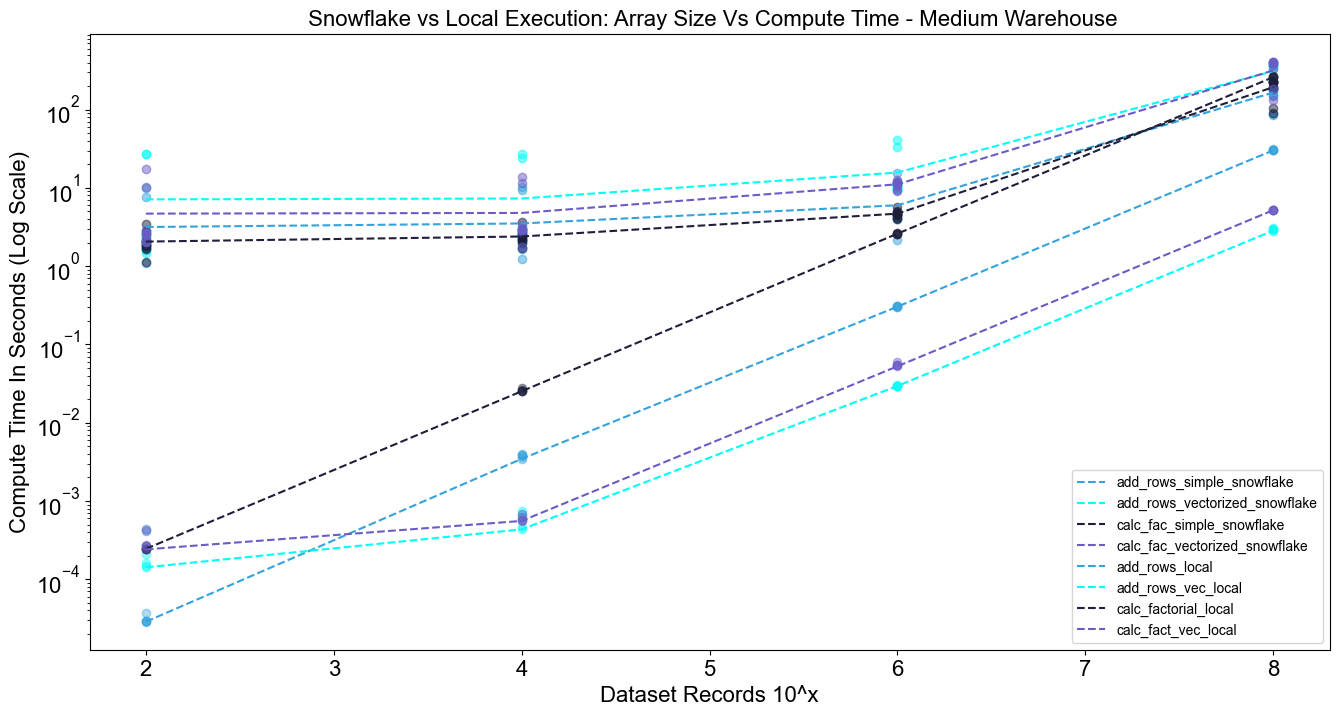

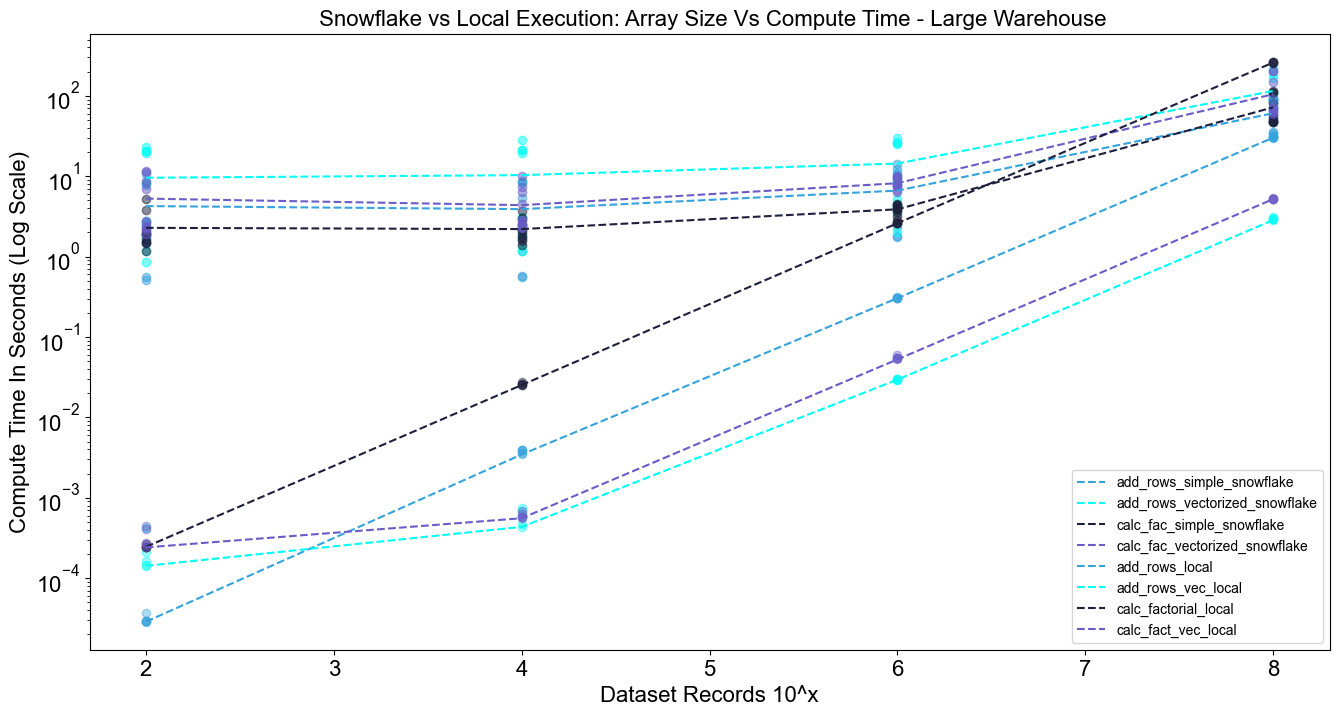

In [233]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16



#plot results
udf_to_color = {'add_rows_simple': '#34A3DD', 
                'add_rows_vectorized': '#00FFF6',
                'calc_fac_simple': '#1D1F3B',
                'calc_fac_vectorized': '#6A5CC7'
                }

for i, lens in enumerate(test_array_lens):
    plt.scatter([lens]*5, add_row_results_list[i], color = '#34A3DD', alpha = 0.4)
    plt.scatter([lens]*5, add_row_vec_result_list[i], color ='#00FFF6', alpha = 0.4)
    plt.scatter([lens]*5, calc_factorials_result_list[i], color = '#1D1F3B', alpha = 0.4)
    plt.scatter([lens]*5, factorials_vectorized_result_list[i], color = '#6A5CC7', alpha = 0.4)

    
plt.plot(test_array_lens, add_row_results_best, label = "add_rows", color = '#34A3DD',  linestyle='--')
plt.plot(test_array_lens, add_row_vec_result_best, label = "add_rows_vec", color = '#00FFF6', linestyle='--')
plt.plot(test_array_lens, calc_factorials_result_best, label = "calc_factorial", color = '#1D1F3B', linestyle='--')
plt.plot(test_array_lens, factorials_vectorized_result_best, label = "calc_fact_vec", color = '#6A5CC7', linestyle='--')


for warehouse in warehouses:
    plt.figure(figsize=(16,8))
    
    results_subset_df = joined_df[joined_df['WAREHOUSE_NAME'] == warehouse]
    
    for udf_name in udf_names:
        udf_results_subset_df = results_subset_df[results_subset_df['UDF'] == udf_name]
        
        dataset_size = np.log10(udf_results_subset_df['ROWS_PRODUCED'].values).tolist()
        execution_time = (udf_results_subset_df['EXECUTION_TIME'] / 1000).values.tolist()
        
        plt.scatter(dataset_size, execution_time, color = udf_to_color[udf_name], alpha = 0.5)
    
        mean_exeuction_time = (udf_results_subset_df.groupby(by = ['ROWS_PRODUCED'])['EXECUTION_TIME'].mean()/1000).values.tolist()
        dataset_size_single = np.sort(np.log10(udf_results_subset_df['ROWS_PRODUCED'].unique())).tolist()


        plt.plot(dataset_size_single, mean_exeuction_time, label = f"{udf_name}_snowflake", color = udf_to_color[udf_name],  linestyle='--')
    

    for i, lens in enumerate(test_array_lens):
        plt.scatter([lens]*5, add_row_results_list[i], color = '#34A3DD', alpha = 0.4)
        plt.scatter([lens]*5, add_row_vec_result_list[i], color ='#00FFF6', alpha = 0.4)
        plt.scatter([lens]*5, calc_factorials_result_list[i], color = '#1D1F3B', alpha = 0.4)
        plt.scatter([lens]*5, factorials_vectorized_result_list[i], color = '#6A5CC7', alpha = 0.4)


    plt.plot(test_array_lens, add_row_results_best, label = "add_rows_local", color = '#34A3DD',  linestyle='--')
    plt.plot(test_array_lens, add_row_vec_result_best, label = "add_rows_vec_local", color = '#00FFF6', linestyle='--')
    plt.plot(test_array_lens, calc_factorials_result_best, label = "calc_factorial_local", color = '#1D1F3B', linestyle='--')
    plt.plot(test_array_lens, factorials_vectorized_result_best, label = "calc_fact_vec_local", color = '#6A5CC7', linestyle='--')

    plt.yscale('log')
    plt.title(f""" Snowflake vs Local Execution: Array Size Vs Compute Time - {warehouse.split("_")[0].capitalize()} Warehouse""")
    plt.ylabel('Compute Time In Seconds (Log Scale)')
    plt.xlabel('Dataset Records 10^x')
    plt.legend()

    #plt.savefig(f'result_charts/snowflake_to_local_execution_example_{warehouse}.png', dpi=600, bbox_inches='tight')
    plt.show()

# Last Just Check Performance when importing Pandas without the batch api

In [52]:
config = configparser.ConfigParser()
config.read('snowflake_creds.config')

connection_parameters = {
    "account": config['snowflake']['account'],
    "user": config['snowflake']['user'],
    "password": config['snowflake']['password'],
    "role": config['snowflake']['role'],
    "warehouse": config['snowflake']['warehouse'],
    "database": config['snowflake']['database'],
    "schema": config['snowflake']['schema']
}

session = Session.builder.configs(connection_parameters).create()

stage_name = "snowpark_functions"

In [13]:
%%writefile "add_rows_simple_with_pandas.py"

import pandas as pd


def add_rows_simple_with_pandas(A, B):
    # call pandas, but don't compute anything
    pd.DataFrame()
    
    return A + B

Overwriting add_rows_simple_with_pandas.py


In [18]:
# Udf for laoding pandas every time
from add_rows_simple_with_pandas import add_rows_simple_with_pandas

@udf(name = "ADD_ROWS_SIMPLE_WITH_PANDAS",
     is_permanent = True,
     stage_location = f"@{stage_name}",
     replace = True,
     imports = [("add_rows_simple_with_pandas.py", "add_rows_simple_with_pandas")],
     packages = ["pandas", "numpy"],
     session = session)

def sf_add_rows_with_pandas(A: float,
                            B: float) -> int:
    
    sum_rows = add_rows_simple_with_pandas(A, B)
    
    return sum_rows

The version of package numpy in the local environment is 1.23.3, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment


In [19]:
session.sql(""" select add_rows_simple_with_pandas(*) from demodb.udf_testing.udf_test limit 10""").show()

------------------------------------
|"ADD_ROWS_SIMPLE_WITH_PANDAS(*)"  |
------------------------------------
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
|5                                 |
------------------------------------



In [49]:
# run the udf
conn = snowflake.connector.connect(
        account = config['snowflake']['account'],
        user = config['snowflake']['user'],
        password = config['snowflake']['password'],
        role=config['snowflake']['role'],
        warehouse = config['snowflake']['warehouse'],
        database=  config['snowflake']['database'],
        schema= config['snowflake']['schema']
        )

In [50]:
# run all udfs on various sized tables on Snowflake

# this took way to long with 10**8 queries, also only going to run 5x + stopped after 10 minutes
test_array_lens = [2, 4, 6, 7]
num_loops = 5
udf_names = ['add_rows_simple_with_pandas', 'add_rows_simple', 'add_rows_vectorized', 'calc_fac_simple',  'calc_fac_vectorized']
warehouses = ['SMALL_TEST_WH', 'LARGE_TEST_WH']
query_ids = []
udf_results = []
length_results = []
loop_num = []
cur = conn.cursor()

for loop in range(0, num_loops):
    for warehouse in warehouses:
        cur.execute(f""" use warehouse {warehouse} """)

        for udf_name in udf_names:
            for record_power in test_array_lens: 

                records_returned = 10 ** record_power

                # lets do this async instead
                #conn.cursor().execute(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                cur.execute_async(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                query_id = cur.sfqid
                #print(query_id)
                query_ids.append(query_id)
                udf_results.append(udf_name)
                length_results.append(records_returned)
                loop_num.append(loop_num)


In [53]:
# rows to return
history_rows = 5000
df = session.sql( f""" select query_id, total_elapsed_time, compilation_time, execution_time, rows_produced, warehouse_name, query_text from table(information_schema.query_history(result_limit => {history_rows})) order by start_time desc """)

results_df = df.to_pandas()

In [54]:
results_df.to_csv('query_summary_with_pandas_all.csv', index=False)

In [56]:
results_df = pd.read_csv('query_summary_with_pandas_all.csv', index_col=False)

In [ ]:
query_ids

In [57]:
query_ids_string = '|'.join(query_ids)

results_df = results_df[results_df['QUERY_ID'].str.contains(query_ids_string)]

# add in udf function that was used:
udf_df = pd.DataFrame({"QUERY_ID": query_ids, "UDF": udf_results})

joined_df = results_df.merge(udf_df, left_on = 'QUERY_ID', right_on = "QUERY_ID", how = 'left')

In [58]:
joined_df.to_csv('query_summary_with_pandas_all_joined.csv', index=False)


In [59]:
joined_df

,QUERY_ID,TOTAL_ELAPSED_TIME,COMPILATION_TIME,EXECUTION_TIME,ROWS_PRODUCED,WAREHOUSE_NAME,QUERY_TEXT,UDF
0,01a7e894-0001-82b4-0000-0004f187353d,152142,194,20468,10000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
1,01a7e894-0001-82b4-0000-0004f1873539,131718,179,8774,1000000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
2,01a7e894-0001-82b4-0000-0004f1873535,128185,176,1138,10000,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
3,01a7e894-0001-82b4-0000-0004f187352d,129180,194,2213,100,LARGE_TEST_WH,select calc_fac_vectorized(*) from demodb.udf_...,calc_fac_vectorized
4,01a7e894-0001-82b4-0000-0004f1873529,204438,200,76080,10000000,LARGE_TEST_WH,select calc_fac_simple(*) from demodb.udf_test...,calc_fac_simple
...,...,...,...,...,...,...,...,...
195,01a7e891-0001-82ae-0000-0004f18742b1,9089,860,8249,100,SMALL_TEST_WH,select add_rows_simple(*) from demodb.udf_test...,add_rows_simple
196,01a7e891-0001-82ae-0000-0004f18742ad,903445,588,902881,10000000,SMALL_TEST_WH,select add_rows_simple_with_pandas(*) from dem...,add_rows_simple_with_pandas
197,01a7e891-0001-82b4-0000-0004f18732fd,122018,889,121212,1000000,SMALL_TEST_WH,select add_rows_simple_with_pandas(*) from dem...,add_rows_simple_with_pandas
198,01a7e891-0001-82b4-0000-0004f18732f9,20158,830,19442,10000,SMALL_TEST_WH,select add_rows_simple_with_pandas(*) from dem...,add_rows_simple_with_pandas


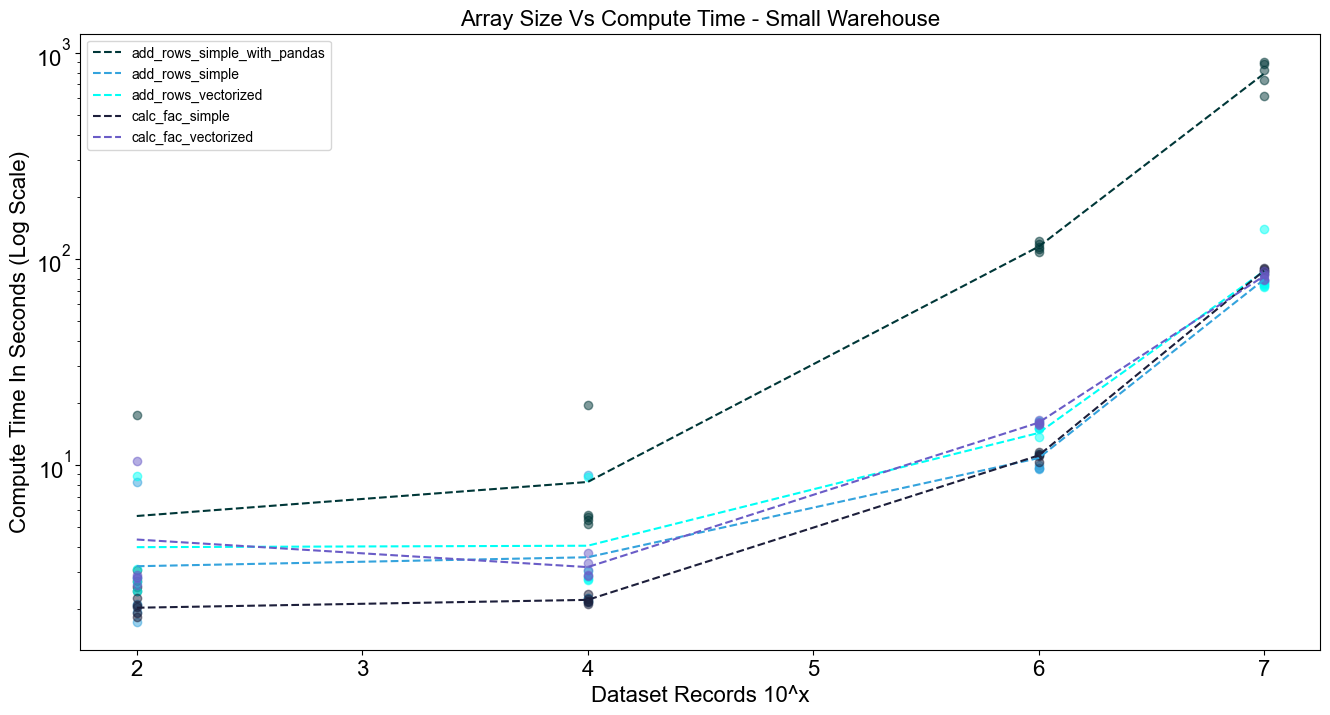

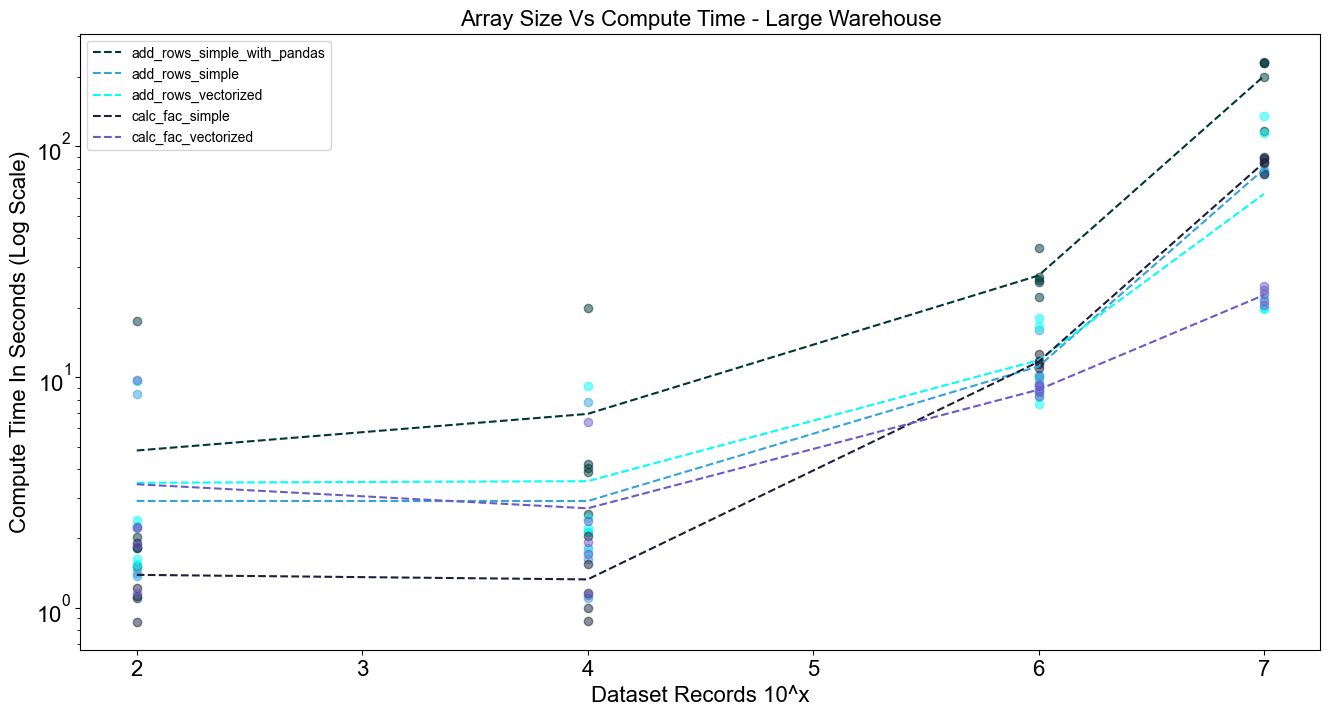

In [61]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16



#plot results
udf_to_color = {'add_rows_simple_with_pandas': '#003738',
                'add_rows_simple': '#34A3DD', 
                'add_rows_vectorized': '#00FFF6',
                'calc_fac_simple': '#1D1F3B',
                'calc_fac_vectorized': '#6A5CC7'
                }


for warehouse in warehouses:
    plt.figure(figsize=(16,8))
    
    results_subset_df = joined_df[joined_df['WAREHOUSE_NAME'] == warehouse]
    
    for udf_name in udf_names:
        udf_results_subset_df = results_subset_df[results_subset_df['UDF'] == udf_name]
        
        dataset_size = np.log10(udf_results_subset_df['ROWS_PRODUCED'].values).tolist()
        execution_time = (udf_results_subset_df['EXECUTION_TIME'] / 1000).values.tolist()
        
        plt.scatter(dataset_size, execution_time, color = udf_to_color[udf_name], alpha = 0.5)
    
        mean_exeuction_time = (udf_results_subset_df.groupby(by = ['ROWS_PRODUCED'])['EXECUTION_TIME'].mean()/1000).values.tolist()
        dataset_size_single = np.sort(np.log10(udf_results_subset_df['ROWS_PRODUCED'].unique())).tolist()


        plt.plot(dataset_size_single, mean_exeuction_time, label = f"{udf_name}", color = udf_to_color[udf_name],  linestyle='--')
    

    plt.yscale('log')
    plt.title(f"""Array Size Vs Compute Time - {warehouse.split("_")[0].capitalize()} Warehouse""")
    plt.ylabel('Compute Time In Seconds (Log Scale)')
    plt.xlabel('Dataset Records 10^x')
    plt.legend()
    plt.savefig(f'result_charts/snowflake_execution_example_all_with_pandas_{warehouse}.png', dpi=600, bbox_inches='tight')
    plt.show()

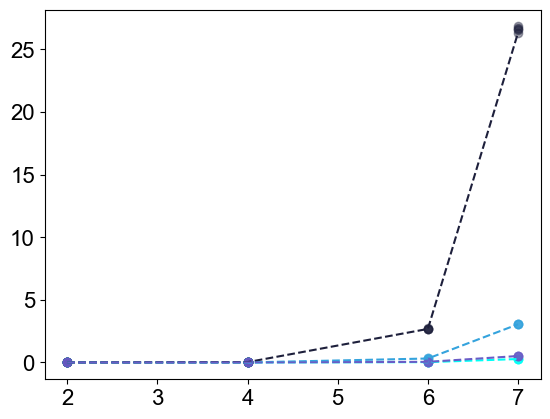

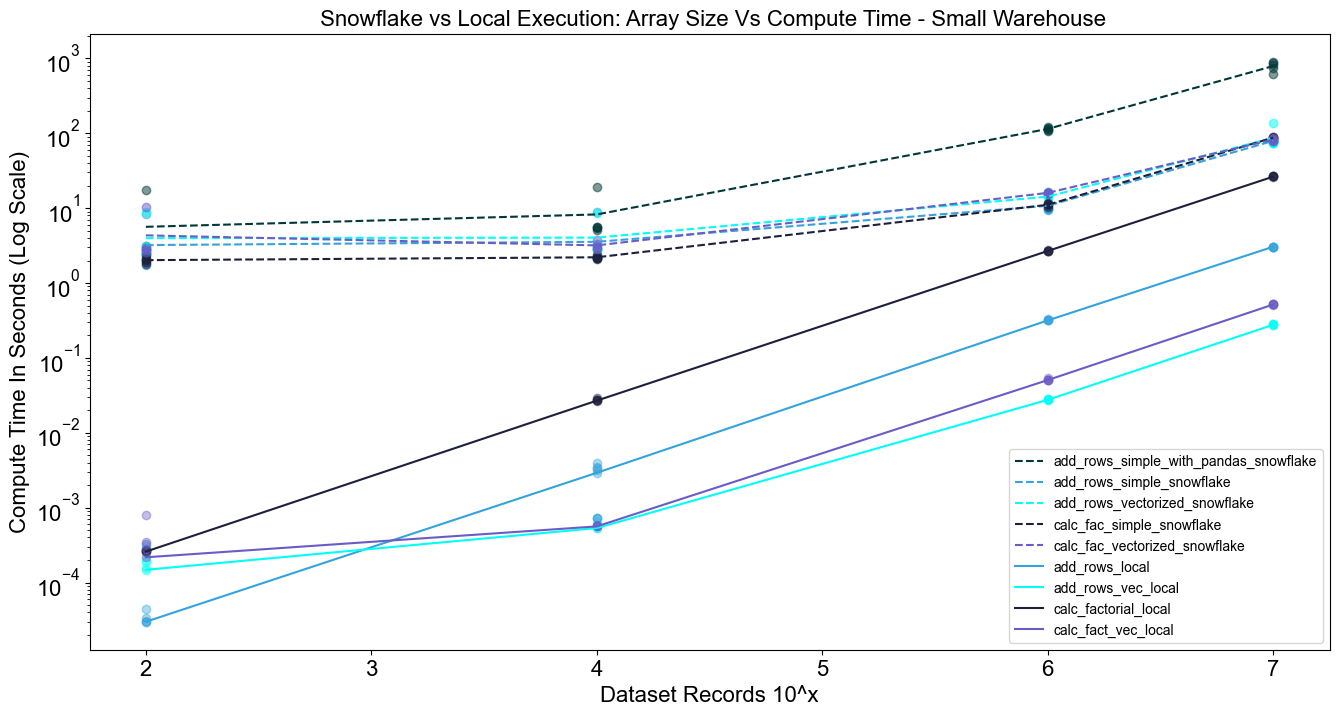

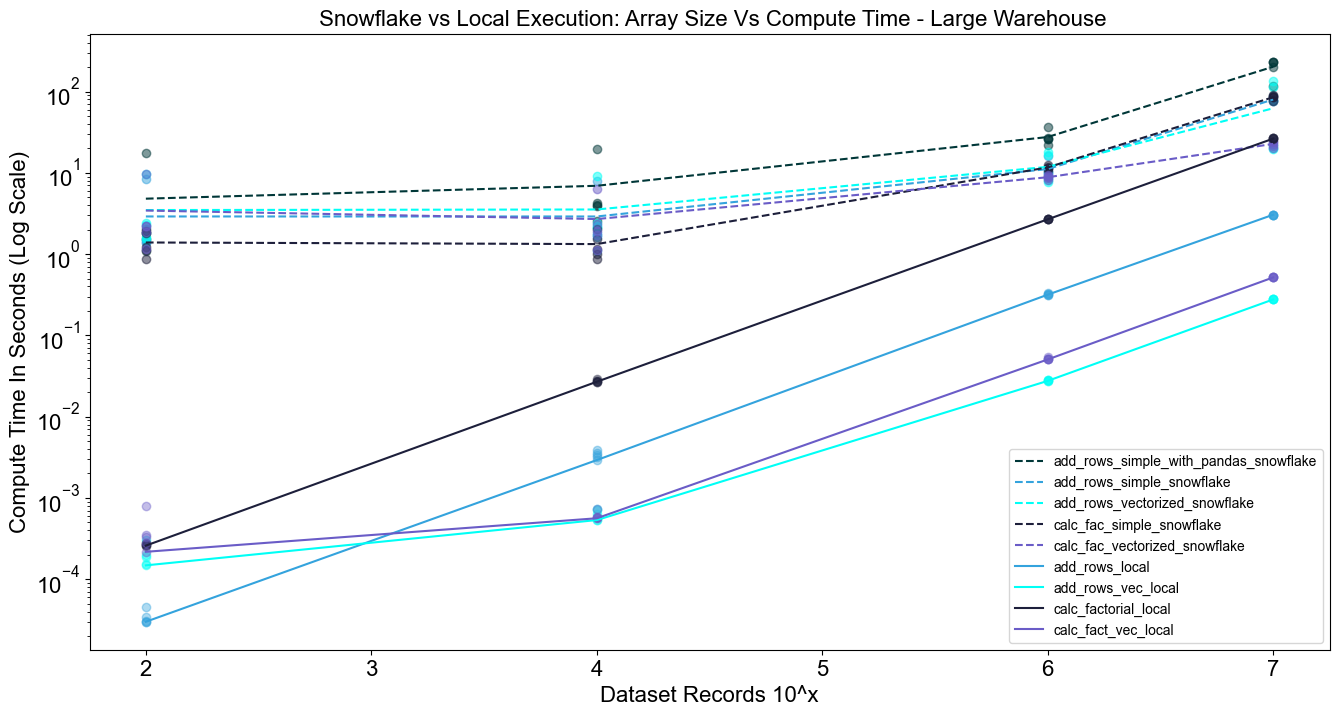

In [75]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16



#plot results
udf_to_color = {'add_rows_simple_with_pandas': '#003738',
                'add_rows_simple': '#34A3DD', 
                'add_rows_vectorized': '#00FFF6',
                'calc_fac_simple': '#1D1F3B',
                'calc_fac_vectorized': '#6A5CC7'
                }

for i, lens in enumerate(test_array_lens):
    plt.scatter([lens]*5, add_row_results_list[i], color = '#34A3DD', alpha = 0.4)
    plt.scatter([lens]*5, add_row_vec_result_list[i], color ='#00FFF6', alpha = 0.4)
    plt.scatter([lens]*5, calc_factorials_result_list[i], color = '#1D1F3B', alpha = 0.4)
    plt.scatter([lens]*5, factorials_vectorized_result_list[i], color = '#6A5CC7', alpha = 0.4)

    
plt.plot(test_array_lens, add_row_results_best, label = "add_rows", color = '#34A3DD',  linestyle='--')
plt.plot(test_array_lens, add_row_vec_result_best, label = "add_rows_vec", color = '#00FFF6', linestyle='--')
plt.plot(test_array_lens, calc_factorials_result_best, label = "calc_factorial", color = '#1D1F3B', linestyle='--')
plt.plot(test_array_lens, factorials_vectorized_result_best, label = "calc_fact_vec", color = '#6A5CC7', linestyle='--')


for warehouse in warehouses:
    plt.figure(figsize=(16,8))
    
    results_subset_df = joined_df[joined_df['WAREHOUSE_NAME'] == warehouse]
    
    for udf_name in udf_names:
        udf_results_subset_df = results_subset_df[results_subset_df['UDF'] == udf_name]
        
        dataset_size = np.log10(udf_results_subset_df['ROWS_PRODUCED'].values).tolist()
        execution_time = (udf_results_subset_df['EXECUTION_TIME'] / 1000).values.tolist()
        
        plt.scatter(dataset_size, execution_time, color = udf_to_color[udf_name], alpha = 0.5)
    
        mean_exeuction_time = (udf_results_subset_df.groupby(by = ['ROWS_PRODUCED'])['EXECUTION_TIME'].mean()/1000).values.tolist()
        dataset_size_single = np.sort(np.log10(udf_results_subset_df['ROWS_PRODUCED'].unique())).tolist()


        plt.plot(dataset_size_single, mean_exeuction_time, label = f"{udf_name}_snowflake", color = udf_to_color[udf_name],  linestyle='--')
    

    for i, lens in enumerate(test_array_lens):
        plt.scatter([lens]*5, add_row_results_list[i], color = '#34A3DD', alpha = 0.4)
        plt.scatter([lens]*5, add_row_vec_result_list[i], color ='#00FFF6', alpha = 0.4)
        plt.scatter([lens]*5, calc_factorials_result_list[i], color = '#1D1F3B', alpha = 0.4)
        plt.scatter([lens]*5, factorials_vectorized_result_list[i], color = '#6A5CC7', alpha = 0.4)


    plt.plot(test_array_lens, add_row_results_best, label = "add_rows_local", color = '#34A3DD',  linestyle='-')
    plt.plot(test_array_lens, add_row_vec_result_best, label = "add_rows_vec_local", color = '#00FFF6', linestyle='-')
    plt.plot(test_array_lens, calc_factorials_result_best, label = "calc_factorial_local", color = '#1D1F3B', linestyle='-')
    plt.plot(test_array_lens, factorials_vectorized_result_best, label = "calc_fact_vec_local", color = '#6A5CC7', linestyle='-')

    plt.yscale('log')
    plt.title(f""" Snowflake vs Local Execution: Array Size Vs Compute Time - {warehouse.split("_")[0].capitalize()} Warehouse""")
    plt.ylabel('Compute Time In Seconds (Log Scale)')
    plt.xlabel('Dataset Records 10^x')
    plt.legend()

    plt.savefig(f'result_charts/snowflake_to_local_execution_example_all_{warehouse}.png', dpi=600, bbox_inches='tight')
    plt.show()

# Checking Batch Size Impact

In [77]:
max_batch_sizes = [10000, 100000, 1000000, 10000000]

In [78]:

for size in max_batch_sizes:
    from factorials_vectorized import factorials_vectorized

    @udf(name = f"CALC_FAC_VECTORIZED_{size}",
         is_permanent = True,
         stage_location = f"@{stage_name}",
         replace = True,
         imports = [("factorials_vectorized.py", "factorials_vectorized")],
         packages = ["pandas", "numpy", "scipy"],
         session = session,
         max_batch_size = size)

    def sf_add_rows_vec(df: PandasDataFrame[float, float]) -> PandasSeries[int]:

        sum_factorials = factorials_vectorized(df)

        return sum_factorials

The version of package numpy in the local environment is 1.23.3, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment
The version of package scipy in the local environment is 1.9.3, which does not fit the criteria for the requirement scipy. Your UDF might not work when the package version is different between the server and your local environment
The version of package numpy in the local environment is 1.23.3, which does not fit the criteria for the requirement numpy. Your UDF might not work when the package version is different between the server and your local environment
The version of package scipy in the local environment is 1.9.3, which does not fit the criteria for the requirement scipy. Your UDF might not work when the package version is different between the server and your local environment
The version of package numpy in the local environment is 1.23.3, which doe

In [79]:
test_array_lens = [4, 6, 8]
num_loops = 5
udf_names = [f"CALC_FAC_VECTORIZED_{size}" for size in max_batch_sizes]
warehouses = ['SMALL_TEST_WH', 'LARGE_TEST_WH']
query_ids = []
udf_results = []
length_results = []
loop_num = []
cur = conn.cursor()

for loop in range(0, num_loops):
    for warehouse in warehouses:
        cur.execute(f""" use warehouse {warehouse} """)

        for udf_name in udf_names:
            for record_power in test_array_lens: 

                records_returned = 10 ** record_power

                # lets do this async instead
                #conn.cursor().execute(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                cur.execute_async(f""" select {udf_name}(*) from demodb.udf_testing.udf_test limit {records_returned}""")

                query_id = cur.sfqid
                #print(query_id)
                query_ids.append(query_id)
                udf_results.append(udf_name)
                length_results.append(records_returned)
                loop_num.append(loop_num)

In [84]:
# rows to return
history_rows = 5000
df = session.sql( f""" select query_id, total_elapsed_time, compilation_time, execution_time, rows_produced, warehouse_name, query_text from table(information_schema.query_history(result_limit => {history_rows})) order by start_time desc """)

results_df = df.to_pandas()

In [85]:
query_ids_string = '|'.join(query_ids)

results_df = results_df[results_df['QUERY_ID'].str.contains(query_ids_string)]

# add in udf function that was used:
udf_df = pd.DataFrame({"QUERY_ID": query_ids, "UDF": udf_results})

joined_df = results_df.merge(udf_df, left_on = 'QUERY_ID', right_on = "QUERY_ID", how = 'left')

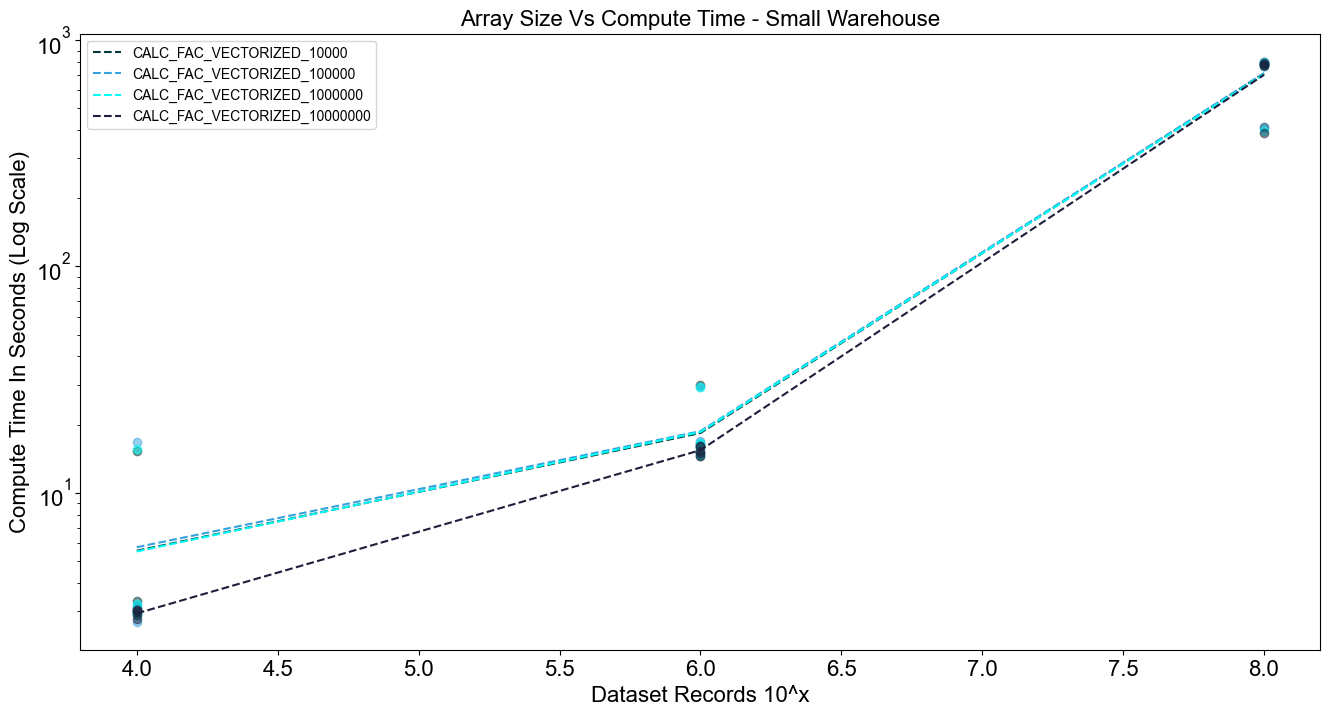

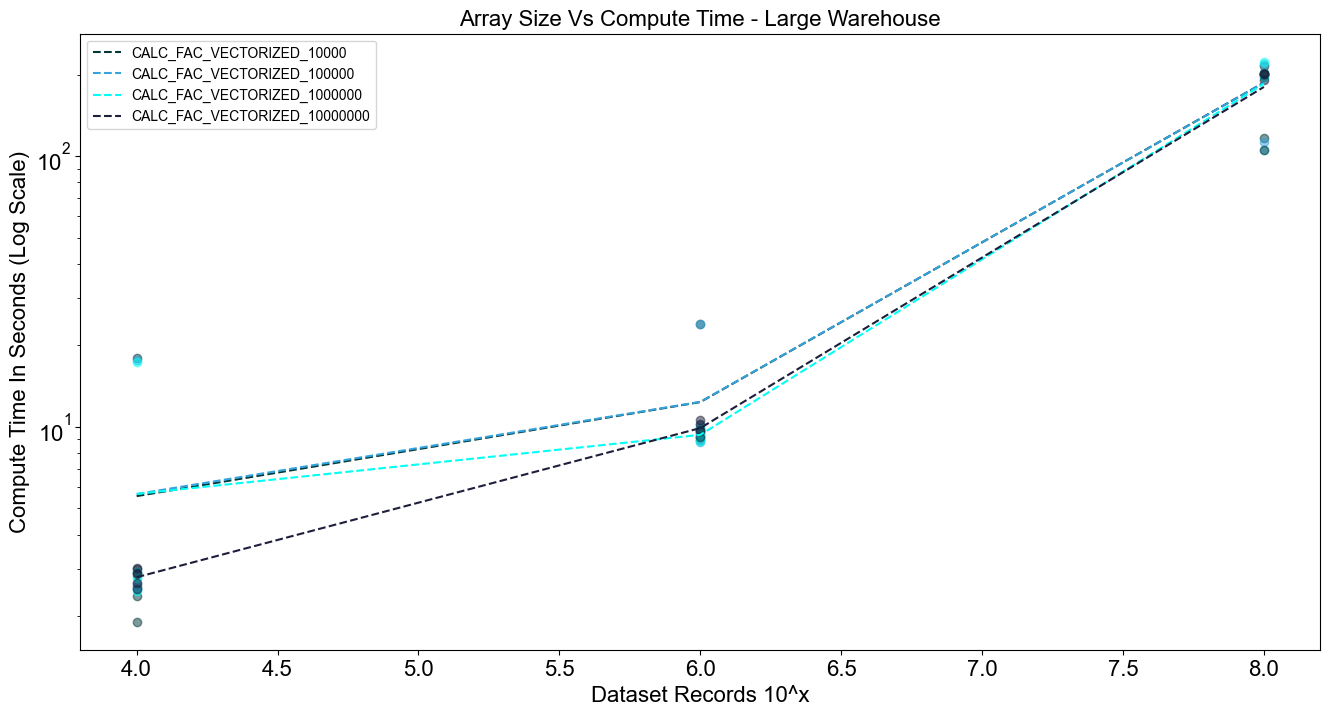

In [86]:
plt.rcParams['font.family'] = "Arial"
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16



#plot results
udf_to_color = {'CALC_FAC_VECTORIZED_10000': '#003738',
                'CALC_FAC_VECTORIZED_100000': '#34A3DD', 
                'CALC_FAC_VECTORIZED_1000000': '#00FFF6',
                'CALC_FAC_VECTORIZED_10000000': '#1D1F3B',
                }


for warehouse in warehouses:
    plt.figure(figsize=(16,8))
    
    results_subset_df = joined_df[joined_df['WAREHOUSE_NAME'] == warehouse]
    
    for udf_name in udf_names:
        udf_results_subset_df = results_subset_df[results_subset_df['UDF'] == udf_name]
        
        dataset_size = np.log10(udf_results_subset_df['ROWS_PRODUCED'].values).tolist()
        execution_time = (udf_results_subset_df['EXECUTION_TIME'] / 1000).values.tolist()
        
        plt.scatter(dataset_size, execution_time, color = udf_to_color[udf_name], alpha = 0.5)
    
        mean_exeuction_time = (udf_results_subset_df.groupby(by = ['ROWS_PRODUCED'])['EXECUTION_TIME'].mean()/1000).values.tolist()
        dataset_size_single = np.sort(np.log10(udf_results_subset_df['ROWS_PRODUCED'].unique())).tolist()


        plt.plot(dataset_size_single, mean_exeuction_time, label = f"{udf_name}", color = udf_to_color[udf_name],  linestyle='--')
    

    plt.yscale('log')
    plt.title(f"""Array Size Vs Compute Time - {warehouse.split("_")[0].capitalize()} Warehouse""")
    plt.ylabel('Compute Time In Seconds (Log Scale)')
    plt.xlabel('Dataset Records 10^x')
    plt.legend()
    plt.savefig(f'result_charts/snowflake_execution_with_variable_batch_size_{warehouse}.png', dpi=600, bbox_inches='tight')
    plt.show()

In [87]:
# size of numpy array:
test_array = create_test_array(array_len_power = 8)
test_array.size

200000000

In [89]:
200000000   *  10 ** -6

200.0